In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
block_size = 256
batch_size = 16
max_iters = 5000
learning_rate = 1e-2
eval_iters = 250

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("drive/My Drive/wizard_of_oz.txt", encoding='utf-8') as f:
    text = f.read()

In [ ]:
chars = sorted(set(text))
print(len(chars),chars)

81 ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']


In [ ]:
vocab_size = len(chars)

In [ ]:
string_to_int = {ch:i for i,ch in enumerate(chars)}
int_to_string = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)

In [ ]:
data, len(text)

(tensor([80,  1,  1,  ..., 29, 67, 57]), 232309)

In [ ]:
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split:str):
  data = train_data if split=="train" else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i : i+block_size] for i in ix])
  y = torch.stack([data[i+1 : i+block_size+1] for i in ix])
  x,y = x.to(device), y.to(device)
  return x,y

In [ ]:
x,y = get_batch('train')
# print(x)
# print(y)

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
              X,Y = get_batch(split)
              logits, loss = model(X,Y)
              losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, index, targets=None):
        logits = self.token_embedding_table(index)
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape # batch, time, channels(vocab size)
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self.forward(index) # get prediction
            logits = logits[:, -1, :] # get the last time step, (B,C)
            probs = F.softmax(logits, dim=-1) # apply softmax to get probs
            index_next = torch.multinomial(probs, num_samples=1) # sample from distribution (B,1)
            index = torch.cat((index, index_next), dim=1) # append sampled to get sequence (B, T+1)
        return index

In [ ]:
model = BigramLanguageModel(vocab_size)

In [ ]:
m = model.to(device)

In [ ]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
context

tensor([[0]], device='cuda:0')

In [ ]:
generate_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generate_chars)


B3l!dAW[L,Ee8HpT* ][__,c2ue!RY*v(DGAz111J!a[,LFIp;ly:cy5Ll ,fs0&);:a﻿)uv]eR!"7ll05vCkzu4V(0ATGBN:c0BosXX-XX9"hb(0qYq_Sg&Hc
!z
aETag.2p4CJ*;oMKwkGUFc0h8PA l.d)7i[_nQWvJs
[)N!oa[g._8UStVL0OQMjq8(r
mY2)Y2mXo[siDGDSoC.XB!4By8bfs
pzHeBN.iuF 2WLJwk7K&_oJSMEcKFiJ&B)Kx2I
SC9Li9x)&027LX-&0,!tZT'ujwQNvFIaEBAxO;owQ4U.AlH:.AoRb1IoY2B)!IX_J5D]cB)k﻿,qFIdXCCuoDMNN]a&K*P3zpre!LE:hLe8G6?bSmt]pAl-EH"J]0vJ"7e!czJo&A"WR7:]pNds1*Y[ ,?h5[( IL)iAz&BW2
a(0&_VKVbiY*'Xr0H!mn)'pZKdCp"v_iQ?8Dn-bH2);:S0BDBtpTejx[9
QVPjZ.dMy


step: 0, train loss: 4.8869, val loss: 4.8910
step: 250, train loss: 2.8172, val loss: 2.8482
step: 500, train loss: 2.5116, val loss: 2.5473
step: 750, train loss: 2.4544, val loss: 2.5023
step: 1000, train loss: 2.4393, val loss: 2.4935
step: 1250, train loss: 2.4394, val loss: 2.4852
step: 1500, train loss: 2.4318, val loss: 2.4793
step: 1750, train loss: 2.4330, val loss: 2.4770
step: 2000, train loss: 2.4281, val loss: 2.4755
step: 2250, train loss: 2.4262, val loss: 2.4755
step: 2500, train loss: 2.4241, val loss: 2.4740
step: 2750, train loss: 2.4232, val loss: 2.4746
step: 3000, train loss: 2.4245, val loss: 2.4749
step: 3250, train loss: 2.4252, val loss: 2.4770
step: 3500, train loss: 2.4245, val loss: 2.4752
step: 3750, train loss: 2.4241, val loss: 2.4735
step: 4000, train loss: 2.4212, val loss: 2.4732
step: 4250, train loss: 2.4214, val loss: 2.4708
step: 4500, train loss: 2.4232, val loss: 2.4755
step: 4750, train loss: 2.4239, val loss: 2.4745


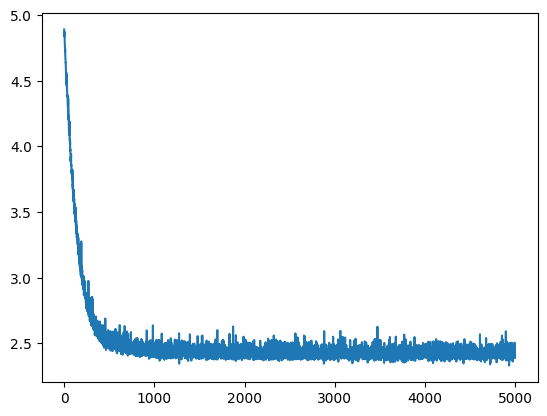

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_list=[]
for iter in range(max_iters):
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")
    xb, yb = get_batch('train')

    logits, loss = model.forward(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

plt.plot(loss_list)

In [ ]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)



"
"
theiersowe foupotheliner
sknd t'(sperklle a gl neg d
" olarery "AUTharel ed y jes he pe. w on fus re t or beacheark whe't l f  stanthe the, matstllinde
"
a:

"H crcueblador the
ad g ore muparurt ppe thningensid cks avere thousstanendougetre ha te ky tincundrofropad ad hy thed sth coaney. wiese hers, stw tro iclong waseraboun



"
trory ard  gg
t hein thas, vesh veka n, f thingorke athe stengen f the p
theroins y o t Wina t eatris ge, A s. abr suncecern he ad nee arf asth g bel g.
d sof d te


In [ ]:
context = torch.tensor([encode("The Wiz")], dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)

The Wizaklad ainer omem nnedgVinde f thouther cend, ire ioughen
ld,"Weng mon. tleskju oon petis aroularain m,



THee sothene a ac hisare pe owas tan bed-thend nd,"Wey
eltheald ad the and we, 7
louthes, snd Wizaunovinkeyoboualered, nd tot wat rvois.
ce t hersll he

tlowoo tek
hed coy Mron litheed tthasheaneres.
" ty win Coy tun. eangintlierys marorpemaleemereche nghe s ters higrod a ofu then.
olaidere the
hery at; y the ruithand omoupebl
I man s glovippoo as fe,
"I'ly  y iD Jir  sexcl adiof[In WI I'," 
